In [144]:
import pandas as pd
import numpy as np
import re
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import decomposition
from nltk.corpus import stopwords
import pickle
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, recall_score, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import svm
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier
from collections import Counter
import matplotlib.pyplot as plt
from jupyterthemes import jtplot
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)
%config InlineBackend.figure_format='retina'

### 1. Read data

In [2]:
df_orig = pd.read_json(open("train.json", "r", encoding="utf8"))

df_orig = df_orig.reset_index()

In [3]:
df_orig.shape

(49352, 16)

In [4]:
# Create 2 classes instead of 3
def label_interest(row):
    if row['interest_level'] == 'high' :
        return 1
    else:
        return 0

In [5]:
df_orig['high_interest_level'] = df_orig.apply(lambda row: label_interest(row), axis=1)

In [6]:
df_orig.high_interest_level.value_counts()

0    45513
1     3839
Name: high_interest_level, dtype: int64

### 1.a Making balanced dataset

In [39]:
from imblearn.under_sampling import RandomUnderSampler

undersample = RandomUnderSampler(sampling_strategy='majority')

In [8]:
df = df_orig

In [9]:
df = df.set_index('index')

### 2. Cleaning description and features columns

In [10]:
def clean_description(desc):
    return re.sub("<.*?>|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|[0-9]", " ", desc)

In [11]:
df['description'] = np.array([ clean_description(desc).lower() for desc in df['description'] ])
df['features'] = df['features'].apply(lambda x: ' '.join(x).lower())

In [12]:
df['description_and_features'] = df['description'] + ' ' + df['features']

In [13]:
df = df[df['description_and_features']!='']
df = df[df['description']!='']
df = df[df['features']!='']

In [14]:
df.high_interest_level.value_counts() # detected class imbalance

0    41329
1     3417
Name: high_interest_level, dtype: int64

In [15]:
df

,bathrooms,bedrooms,building_id,created,description,display_address,features,latitude,listing_id,longitude,manager_id,photos,price,street_address,interest_level,high_interest_level,description_and_features
index,,,,,,,,,,,,,,,,,
4,1.0,1,8579a0b0d54db803821a35a4a615e97a,2016-06-16 05:55:27,spacious bedroom bathroom in williamsburg ...,145 Borinquen Place,dining room pre-war laundry in building dishwa...,40.7108,7170325,-73.9539,a10db4590843d78c784171a107bdacb4,[https://photos.renthop.com/2/7170325_3bb5ac84...,2400,145 Borinquen Place,medium,0,spacious bedroom bathroom in williamsburg ...
6,1.0,2,b8e75fc949a6cd8225b455648a951712,2016-06-01 05:44:33,brand new gut renovated true bedroomfind you...,East 44th,doorman elevator laundry in building dishwashe...,40.7513,7092344,-73.9722,955db33477af4f40004820b4aed804a0,[https://photos.renthop.com/2/7092344_7663c19a...,3800,230 East 44th,low,0,brand new gut renovated true bedroomfind you...
9,1.0,2,cd759a988b8f23924b5a2058d5ab2b49,2016-06-14 15:19:59,flex bedroom with full pressurized wall l...,East 56th Street,doorman elevator laundry in building laundry i...,40.7575,7158677,-73.9625,c8b10a317b766204f08e613cef4ce7a0,[https://photos.renthop.com/2/7158677_c897a134...,3495,405 East 56th Street,medium,0,flex bedroom with full pressurized wall l...
15,1.0,0,bfb9405149bfff42a92980b594c28234,2016-06-28 03:50:23,over sized studio w abundant closets availabl...,East 34th Street,doorman elevator fitness center laundry in bui...,40.7439,7225292,-73.9743,2c3b41f588fbb5234d8a1e885a436cfa,[https://photos.renthop.com/2/7225292_901f1984...,2795,340 East 34th Street,low,0,over sized studio w abundant closets availabl...
16,1.0,3,300d27d8ba2adbcbc8c6f2bcbc1c6f9d,2016-06-28 05:59:06,this spectacular converted bed apartment all...,East 16th Street,doorman elevator loft dishwasher hardwood floo...,40.7348,7226687,-73.9865,30a7951cfc21240e8c46b2d079d292e5,[https://photos.renthop.com/2/7226687_4ea22bf1...,7200,145 East 16th Street,low,0,this spectacular converted bed apartment all...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124000,1.0,3,92bbbf38baadfde0576fc496bd41749c,2016-04-05 03:58:33,there is square feet of recently renovated...,W 171 Street,elevator dishwasher hardwood floors,40.8433,6824800,-73.9396,a61e21da3ba18c7a3d54cfdcc247e1f8,[https://photos.renthop.com/2/6824800_0682be16...,2800,620 W 171 Street,low,0,there is square feet of recently renovated...
124002,1.0,2,5565db9b7cba3603834c4aa6f2950960,2016-04-02 02:25:31,bedroom apartment with updated kitchen rece...,Broadway,common outdoor space cats allowed dogs allowed...,40.8198,6813268,-73.9578,8f90e5e10e8a2d7cf997f016d89230eb,[https://photos.renthop.com/2/6813268_1e6fcc32...,2395,3333 Broadway,medium,0,bedroom apartment with updated kitchen rece...
124004,1.0,1,67997a128056ee1ed7d046bbb856e3c7,2016-04-26 05:42:03,no brokers fee never lived bedroom bathr...,210 Brighton 15th St,dining room elevator pre-war laundry in buildi...,40.5765,6927093,-73.9554,a10db4590843d78c784171a107bdacb4,[https://photos.renthop.com/2/6927093_93a52104...,1850,210 Brighton 15th St,medium,0,no brokers fee never lived bedroom bathr...


### 3a. Word vectorizer

In [16]:
def word_vectorizer(ngram_range, df, column):
    word_vectorizer = CountVectorizer(ngram_range=ngram_range, analyzer='word',stop_words='english')
    sparse_matrix = word_vectorizer.fit_transform(df[column])
    frequencies = sum(sparse_matrix).data
    ngrams_df = pd.DataFrame(frequencies, index=word_vectorizer.get_feature_names(), columns=[column])
    ngrams_df = ngrams_df.reset_index()
    return ngrams_df, word_vectorizer, sparse_matrix

### 3b. TF-IDF vectorizer

In [17]:
def tf_idf_vectorizer(ngram_range, df, column):
    tfidf_vectorizer = TfidfVectorizer(smooth_idf=True,
                                       use_idf=True,
                                       stop_words='english',
                                       ngram_range=ngram_range,
                                       min_df=5,
                                       binary=True)
    dtm = tfidf_vectorizer.fit_transform(df[column])
    tfidf_vocab = np.array(tfidf_vectorizer.get_feature_names())
    df_idf = pd.DataFrame(tfidf_vectorizer.idf_, index=tfidf_vectorizer.get_feature_names(),columns=["idf_weights"])
    df_idf = df_idf.sort_values(by=['idf_weights'], ascending=True)
    return tfidf_vectorizer, dtm, tfidf_vocab, df_idf

### 3.1 TF-IDF vectorizer - unigrams

In [74]:
tfidf_vectorizer, tfidf_matrix, tfidf_vocab, tfidf_df = tf_idf_vectorizer((1,1), df, 'description')

In [19]:
len(tfidf_vocab)

9596

### 5. NMF model

In [21]:
num_top_words = 5

In [22]:
def train_nmf_model(num_topics, num_top_words, data, tfidf_vocab):
    clf = decomposition.NMF(n_components=num_topics, random_state=1, alpha=.01, l1_ratio=.5, max_iter=500)
    doctopic = clf.fit_transform(data)
    doctopic = doctopic / np.sum(doctopic, axis=1, keepdims=True)
    
    topic_words = []
    for topic in clf.components_:
       word_idx = np.argsort(topic)[::-1][0:num_top_words]
       topic_words.append([tfidf_vocab[i] for i in word_idx])
    return doctopic, topic_words

In [23]:
%%time 
matrix_topic_50, topic_words_50=train_nmf_model(50, num_top_words, tfidf_matrix, tfidf_vocab)
matrix_topic_100, topic_words_100=train_nmf_model(100, num_top_words, tfidf_matrix, tfidf_vocab)
matrix_topic_500, topic_words_500=train_nmf_model(500, num_top_words, tfidf_matrix, tfidf_vocab)
matrix_topic_1000, topic_words_1000=train_nmf_model(1000, num_top_words, tfidf_matrix, tfidf_vocab)

/Users/marijamiljkovic/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)
/Users/marijamiljkovic/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
/Users/marijamiljkovic/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.
/Users/marijamiljkovic/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
/Users/marijamiljkovic/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys

CPU times: user 3h 59min 56s, sys: 58.6 s, total: 4h 55s
Wall time: 3h 20min 22s


In [24]:
topic_words_50

[['closet', 'space', 'ample', 'great', 'plenty'],
 ['supports', 'housing', 'bond', 'equal', 'opportunity'],
 ['coopercooper', 'searchrentals', 'seminar', 'buyingseminar', 'testimonials'],
 ['fitness', 'center', 'views', 'amenities', 'art'],
 ['redacted', 'website', 'fee', 'dorota', 'showing'],
 ['recessed', 'baseboard', 'lighting', 'crown', 'moldings'],
 ['deemed', 'omissions', 'errors', 'withdrawal', 'sources'],
 ['queen', 'size', 'bed', 'fit', 'bedrooms'],
 ['restaurants', 'shops', 'bars', 'distance', 'cafes'],
 ['heat', 'water', 'included', 'hot', 'gas'],
 ['elevator', 'laundry', 'super', 'live', 'building'],
 ['hardwood', 'floors', 'features', 'apartment', 'bathroom'],
 ['ceilings', 'high', 'end', 'wood', 'hard'],
 ['brick', 'exposed', 'walls', 'dishwasher', 'accented'],
 ['hgrny', 'vas', 'disclosure', 'deals', 'fax'],
 ['feel', 'happy', 'assist', 'looking', 'search'],
 ['pets', 'allowed', 'beauty', 'guarantors', 'lets'],
 ['fi', 'wi', 'utilities', 'dish', 'purified'],
 ['heart', '

In [25]:
topic_words_100

[['zurilee', 'exterior', 'extensions', 'extension', 'extends'],
 ['supports', 'housing', 'bond', 'equal', 'opportunity'],
 ['coopercooper', 'seminar', 'buyingseminar', 'searchrentals', 'testimonials'],
 ['fitness', 'center', 'hour', 'valet', 'concierge'],
 ['redacted', 'website', 'dorota', 'david', 'white'],
 ['recessed', 'lighting', 'crown', 'moldings', 'baseboard'],
 ['correct', 'intended', 'compiled', 'changes', 'mironproperties'],
 ['queen', 'bed', 'fit', 'sized', 'easily'],
 ['subway', 'lines', 'major', 'fully', 'located'],
 ['water', 'included', 'heat', 'hot', 'gas'],
 ['elevator', 'laundry', 'building', 'doorman', 'room'],
 ['beauty', 'lets', 'make', 'guarantors', 'home'],
 ['state', 'art', 'landscaped', 'fitness', 'lounge'],
 ['dryer', 'washer', 'unit', 'bedroom', 'accented'],
 ['hgrny', 'vas', 'disclosure', 'fax', 'deals'],
 ['text', 'email', 'response', 'mail', 'asap'],
 ['modern', 'finishes', 'appliances', 'featuring', 'inquiries'],
 ['purified', 'circulating', 'uv', 'fi', '

In [26]:
topic_words_500

[['zurilee', 'exterior', 'extensions', 'extension', 'extends'],
 ['supports', 'housing', 'bond', 'equal', 'opportunity'],
 ['buyingseminar', 'seminar', 'searchrentals', 'coopercooper', 'testimonials'],
 ['zurilee', 'exterior', 'extensions', 'extension', 'extends'],
 ['redacted', 'website', 'dorota', 'nathan', 'david'],
 ['recessed', 'lighting', 'crown', 'moldings', 'baseboard'],
 ['correct', 'intended', 'compiled', 'changes', 'mironproperties'],
 ['bedrooms', 'sized', 'queen', 'living', 'beds'],
 ['zurilee', 'exterior', 'extensions', 'extension', 'extends'],
 ['zurilee', 'exterior', 'extensions', 'extension', 'extends'],
 ['zurilee', 'exterior', 'extensions', 'extension', 'extends'],
 ['zurilee', 'exterior', 'extensions', 'extension', 'extends'],
 ['zurilee', 'exterior', 'extensions', 'extension', 'extends'],
 ['zurilee', 'exterior', 'extensions', 'extension', 'extends'],
 ['zurilee', 'exterior', 'extensions', 'extension', 'extends'],
 ['zurilee', 'exterior', 'extensions', 'extension',

In [27]:
topic_words_1000

[['zurilee', 'exterior', 'extensions', 'extension', 'extends'],
 ['supports', 'housing', 'bond', 'equal', 'opportunity'],
 ['buyingseminar', 'searchrentals', 'seminar', 'coopercooper', 'testimonials'],
 ['zurilee', 'exterior', 'extensions', 'extension', 'extends'],
 ['redacted', 'website', 'dorota', 'nathan', 'buildinglive'],
 ['crown', 'moldings', 'cherry', 'baseboard', 'bleached'],
 ['zurilee', 'exterior', 'extensions', 'extension', 'extends'],
 ['correct', 'intended', 'compiled', 'mironproperties', 'changes'],
 ['zurilee', 'exterior', 'extensions', 'extension', 'extends'],
 ['zurilee', 'exterior', 'extensions', 'extension', 'extends'],
 ['zurilee', 'exterior', 'extensions', 'extension', 'extends'],
 ['zurilee', 'exterior', 'extensions', 'extension', 'extends'],
 ['zurilee', 'exterior', 'extensions', 'extension', 'extends'],
 ['zurilee', 'exterior', 'extensions', 'extension', 'extends'],
 ['zurilee', 'exterior', 'extensions', 'extension', 'extends'],
 ['zurilee', 'exterior', 'extensi

In [28]:
df_topic_50 = pd.DataFrame(data=matrix_topic_50)
df_topic_100 = pd.DataFrame(data=matrix_topic_100)
df_topic_500 = pd.DataFrame(data=matrix_topic_500)
df_topic_1000 = pd.DataFrame(data=matrix_topic_1000)

In [78]:
tfidf_df = pd.DataFrame.sparse.from_spmatrix(tfidf_matrix)

In [29]:
df = df.reset_index()

In [30]:
df

,index,bathrooms,bedrooms,building_id,created,description,display_address,features,latitude,listing_id,longitude,manager_id,photos,price,street_address,interest_level,high_interest_level,description_and_features
0,4,1.0,1,8579a0b0d54db803821a35a4a615e97a,2016-06-16 05:55:27,spacious bedroom bathroom in williamsburg ...,145 Borinquen Place,dining room pre-war laundry in building dishwa...,40.7108,7170325,-73.9539,a10db4590843d78c784171a107bdacb4,[https://photos.renthop.com/2/7170325_3bb5ac84...,2400,145 Borinquen Place,medium,0,spacious bedroom bathroom in williamsburg ...
1,6,1.0,2,b8e75fc949a6cd8225b455648a951712,2016-06-01 05:44:33,brand new gut renovated true bedroomfind you...,East 44th,doorman elevator laundry in building dishwashe...,40.7513,7092344,-73.9722,955db33477af4f40004820b4aed804a0,[https://photos.renthop.com/2/7092344_7663c19a...,3800,230 East 44th,low,0,brand new gut renovated true bedroomfind you...
2,9,1.0,2,cd759a988b8f23924b5a2058d5ab2b49,2016-06-14 15:19:59,flex bedroom with full pressurized wall l...,East 56th Street,doorman elevator laundry in building laundry i...,40.7575,7158677,-73.9625,c8b10a317b766204f08e613cef4ce7a0,[https://photos.renthop.com/2/7158677_c897a134...,3495,405 East 56th Street,medium,0,flex bedroom with full pressurized wall l...
3,15,1.0,0,bfb9405149bfff42a92980b594c28234,2016-06-28 03:50:23,over sized studio w abundant closets availabl...,East 34th Street,doorman elevator fitness center laundry in bui...,40.7439,7225292,-73.9743,2c3b41f588fbb5234d8a1e885a436cfa,[https://photos.renthop.com/2/7225292_901f1984...,2795,340 East 34th Street,low,0,over sized studio w abundant closets availabl...
4,16,1.0,3,300d27d8ba2adbcbc8c6f2bcbc1c6f9d,2016-06-28 05:59:06,this spectacular converted bed apartment all...,East 16th Street,doorman elevator loft dishwasher hardwood floo...,40.7348,7226687,-73.9865,30a7951cfc21240e8c46b2d079d292e5,[https://photos.renthop.com/2/7226687_4ea22bf1...,7200,145 East 16th Street,low,0,this spectacular converted bed apartment all...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44741,124000,1.0,3,92bbbf38baadfde0576fc496bd41749c,2016-04-05 03:58:33,there is square feet of recently renovated...,W 171 Street,elevator dishwasher hardwood floors,40.8433,6824800,-73.9396,a61e21da3ba18c7a3d54cfdcc247e1f8,[https://photos.renthop.com/2/6824800_0682be16...,2800,620 W 171 Street,low,0,there is square feet of recently renovated...
44742,124002,1.0,2,5565db9b7cba3603834c4aa6f2950960,2016-04-02 02:25:31,bedroom apartment with updated kitchen rece...,Broadway,common outdoor space cats allowed dogs allowed...,40.8198,6813268,-73.9578,8f90e5e10e8a2d7cf997f016d89230eb,[https://photos.renthop.com/2/6813268_1e6fcc32...,2395,3333 Broadway,medium,0,bedroom apartment with updated kitchen rece...
44743,124004,1.0,1,67997a128056ee1ed7d046bbb856e3c7,2016-04-26 05:42:03,no brokers fee never lived bedroom bathr...,210 Brighton 15th St,dining room elevator pre-war laundry in buildi...,40.5765,6927093,-73.9554,a10db4590843d78c784171a107bdacb4,[https://photos.renthop.com/2/6927093_93a52104...,1850,210 Brighton 15th St,medium,0,no brokers fee never lived bedroom bathr...
44744,124008,1.0,2,3c0574a740154806c18bdf1fddd3d966,2016-04-19 02:47:33,wonderful bright chelsea bedroom apartment o...,West 21st Street,pre-war laundry in unit dishwasher no fee outd...,40.7448,6892816,-74.0017,c3cd45f4381ac371507090e9ffabea80,[https://photos.renthop.com/2/6892816_1a8d087a...,4195,350 West 21st Street,medium,0,wonderful bright chelsea bedroom apartment o...


In [31]:
df_topic_50['high_interest_level'] = df['high_interest_level']
df_topic_50['index'] = df['index']

df_topic_100['high_interest_level'] = df['high_interest_level']
df_topic_100['index'] = df['index']

df_topic_500['high_interest_level'] = df['high_interest_level']
df_topic_500['index'] = df['index']

df_topic_1000['high_interest_level'] = df['high_interest_level']
df_topic_1000['index'] = df['index']



In [81]:
tfidf_df['high_interest_level'] = df['high_interest_level']
tfidf_df['index'] = df['index']

In [32]:
df_topic_50 = df_topic_50.dropna()
df_topic_100 = df_topic_100.dropna()
df_topic_500 = df_topic_500.dropna()
df_topic_1000 = df_topic_1000.dropna()

In [130]:
df_topic_50.to_csv('df_topic_50.csv')
df_topic_100.to_csv('df_topic_100.csv')
df_topic_500.to_csv('df_topic_500.csv')
df_topic_1000.to_csv('df_topic_1000.csv')
tfidf_df.to_csv('tfidf_df.csv')

In [21]:
# df_topic_50 = pd.read_csv('df_topic_50.csv')
# df_topic_100 = pd.read_csv('df_topic_100.csv')
# df_topic_500 = pd.read_csv('df_topic_500.csv')
# df_topic_1000 = pd.read_csv('df_topic_1000.csv')
# tfidf_df = pd.read_csv('tfidf_df.csv')

In [22]:
# df_topic_50 = df_topic_50.drop(columns='Unnamed: 0')
# df_topic_100 = df_topic_100.drop(columns='Unnamed: 0')
# df_topic_500 = df_topic_500.drop(columns='Unnamed: 0')
# df_topic_1000  =df_topic_1000.drop(columns='Unnamed: 0')
# tfidf_df = tfidf_df.drop(columns='Unnamed: 0')

### 7. Classification - Random Forest

In [62]:
%%time
experiment_dfs = [df_topic_1000, tfidf_df]
exp = 0

for experiment_df in experiment_dfs:

    X = experiment_df.iloc[:, :-2]
    Y = experiment_df[['high_interest_level']]
    
    # Undersampling
    X, Y = undersample.fit_resample(X, Y)
        
    # Train-test split
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = .20, random_state = 40)
    
    # Train Random Forest Classifier
    model_rf = RandomForestClassifier(max_depth=300, random_state=0)
    model_rf.fit(X_train, Y_train)
    
    print('EXPERIMENT no.', exp)
    
    print('\nRESULTS ON TRAIN SET:')
    
    # Prediction on train 
    rf_predictions_train = model_rf.predict(X_train)
    
    print('\nACCURACY:')
    print(accuracy_score(Y_train, rf_predictions_train))
    
    print('\nRECALL SCORE:')
    print(recall_score(Y_train, rf_predictions_train))
    
    print('***********************************')
    
    print('\nRESULTS ON TEST SET:')

    # Prediction on test 
    rf_predictions_test = model_rf.predict(X_test)
    
    print('\nACCURACY:')
    print(accuracy_score(Y_test, rf_predictions_test))
    
    
    print('\nRECALL SCORE:')
    print(recall_score(Y_test, rf_predictions_test))
    
    print('***********************************')
    
    exp += 1

/Users/marijamiljkovic/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


EXPERIMENT no. 0

RESULTS ON TRAIN SET:

ACCURACY:
0.9828414351851852

RECALL SCORE:
0.8185104844540854
***********************************

RESULTS ON TEST SET:

ACCURACY:
0.9206110403888439

RECALL SCORE:
0.1111111111111111
***********************************


/Users/marijamiljkovic/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


EXPERIMENT no. 1

RESULTS ON TRAIN SET:

ACCURACY:
0.9783495362610347

RECALL SCORE:
0.7470544918998527
***********************************

RESULTS ON TEST SET:

ACCURACY:
0.917877094972067

RECALL SCORE:
0.11269614835948645
***********************************
CPU times: user 2min 11s, sys: 811 ms, total: 2min 12s
Wall time: 2min 10s


### 8. Classification - SVM

In [56]:
%%time
experiment_dfs = [tfidf_df, df_topic_50, df_topic_100, df_topic_500, df_topic_1000]


exp = 0

for experiment_df in experiment_dfs:

    print('\nEXPERIMENT NO. ', exp)
    
    X = experiment_df.iloc[:, :-2]
    Y = experiment_df[['high_interest_level']]
    
    # Undersampling
    X, Y = undersample.fit_resample(X, Y)
        
    # Train-test split
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = .20, random_state = 40)
    
    X_train = np.array(X_train)
    X_test = np.array(X_test)
    Y_train = np.ravel(Y_train)
    Y_test = np.ravel(Y_test)
            
    # Train SVM
    model_svm = svm.SVC(kernel='poly')
    model_svm.fit(X_train, Y_train)
    
    print('\nRESULTS ON TRAIN SET:')
    
    # Prediction on train
    svm_predictions_train = model_svm.predict(X_train)
    
    print('\nACCURACY:')
    print(accuracy_score(Y_train, svm_predictions_train))
    
    
    print('\nRECALL SCORE:')
    print(recall_score(Y_train, svm_predictions_train))

    print('***********************************')
    
    print('\nRESULTS ON TEST SET:')
    
    # Prediction on test
    svm_predictions_test = model_svm.predict(X_test)
    
    print('\nACCURACY:')
    print(accuracy_score(Y_test, svm_predictions_test))
    
    print('\nRECALL SCORE:')
    print(recall_score(Y_test, svm_predictions_test))
    
    print('***********************************')
    
    
    exp += 1


EXPERIMENT NO.  0

RESULTS ON TRAIN SET:

ACCURACY:
0.7501835535976505

RECALL SCORE:
0.8354289940828402
***********************************

RESULTS ON TEST SET:

ACCURACY:
0.6343612334801763

RECALL SCORE:
0.7232524964336662
***********************************

EXPERIMENT NO.  1

RESULTS ON TRAIN SET:

ACCURACY:
0.7936857562408223

RECALL SCORE:
0.8857248520710059
***********************************

RESULTS ON TEST SET:

ACCURACY:
0.631424375917768

RECALL SCORE:
0.7646219686162625
***********************************

EXPERIMENT NO.  2

RESULTS ON TRAIN SET:

ACCURACY:
0.8447136563876652

RECALL SCORE:
0.8827662721893491
***********************************

RESULTS ON TEST SET:

ACCURACY:
0.6688693098384728

RECALL SCORE:
0.7517831669044223
***********************************

EXPERIMENT NO.  3

RESULTS ON TRAIN SET:

ACCURACY:
0.8276431718061674

RECALL SCORE:
0.9341715976331361
***********************************

RESULTS ON TEST SET:

ACCURACY:
0.6607929515418502

RECALL SCORE:


### 9. KNN Classification

In [57]:
%%time
experiment_dfs = [tfidf_df, df_topic_50, df_topic_100, df_topic_500, df_topic_1000]

exp = 0

for experiment_df in experiment_dfs:

    X = experiment_df.iloc[:, :-2]
    Y = experiment_df[['high_interest_level']]
    
    # Undersampling
    X, Y = undersample.fit_resample(X, Y)
    
    # Train-test split
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = .20, random_state = 40)
    
    X_train = X_train.as_matrix()
    Y_train = Y_train.as_matrix()
    X_test = X_test.as_matrix()
    Y_test = Y_test.as_matrix()
    
    # Train KNN
    neigh = KNeighborsClassifier()
    neigh.fit(X_train, Y_train)
    
    print('\nRESULTS ON TRAIN SET:')
    
    # Prediction on train
    neigh_predictions = neigh.predict(X_train)
    
    print('\nACCURACY:')
    print(accuracy_score(Y_train, neigh_predictions))
    
    print('\nRECALL SCORE:')
    print(recall_score(Y_train, neigh_predictions))
    
    print('***********************************')
    
    print('\nRESULTS ON TEST SET:')
    
    # Prediction on test
    neigh_predictions_test = neigh.predict(X_test)
    
    print('\nACCURACY:')
    print(accuracy_score(Y_test, neigh_predictions_test))
       
    print('\nRECALL SCORE:')
    print(recall_score(Y_test, neigh_predictions_test))
    
    
    exp += 1


RESULTS ON TRAIN SET:


/Users/marijamiljkovic/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  app.launch_new_instance()
/Users/marijamiljkovic/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/marijamiljkovic/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/marijamiljkovic/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/marijamiljkovic/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel(


ACCURACY:
0.7382525697503671

RECALL SCORE:
0.7640532544378699
***********************************

RESULTS ON TEST SET:

ACCURACY:
0.5991189427312775

RECALL SCORE:
0.6490727532097005

RESULTS ON TRAIN SET:


/Users/marijamiljkovic/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  app.launch_new_instance()
/Users/marijamiljkovic/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/marijamiljkovic/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/marijamiljkovic/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/marijamiljkovic/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel(


ACCURACY:
0.7463289280469897

RECALL SCORE:
0.7692307692307693
***********************************

RESULTS ON TEST SET:

ACCURACY:
0.6167400881057269

RECALL SCORE:
0.651925820256776


/Users/marijamiljkovic/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  app.launch_new_instance()
/Users/marijamiljkovic/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/marijamiljkovic/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/marijamiljkovic/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/marijamiljkovic/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel(


RESULTS ON TRAIN SET:

ACCURACY:
0.7534875183553598

RECALL SCORE:
0.7544378698224852
***********************************

RESULTS ON TEST SET:

ACCURACY:
0.6240822320117474

RECALL SCORE:
0.6105563480741797


/Users/marijamiljkovic/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  app.launch_new_instance()
/Users/marijamiljkovic/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/marijamiljkovic/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/marijamiljkovic/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/marijamiljkovic/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel(


RESULTS ON TRAIN SET:

ACCURACY:
0.7477973568281938

RECALL SCORE:
0.7629437869822485
***********************************

RESULTS ON TEST SET:

ACCURACY:
0.6138032305433186

RECALL SCORE:
0.644793152639087
CPU times: user 1min 25s, sys: 389 ms, total: 1min 26s
Wall time: 1min 26s


### 10. Nearest neighbours

In [58]:
experiment_dfs = [ df_topic_50, df_topic_100, df_topic_500, df_topic_1000]
exp = 0

for experiment_df in experiment_dfs:
    
    X = experiment_df.iloc[:, :-2]
        
    nbrs = NearestNeighbors(n_neighbors=5, algorithm='ball_tree').fit(X)
    distances, indices = nbrs.kneighbors(X)
    print('\nEXPERIMENT no.', exp)
    
    indices = pd.DataFrame(indices)
    
    print(indices.head(20))
    exp = exp + 1
    #indices.to_csv('indices_'+(str(exp)))


EXPERIMENT no. 0
        0      1      2      3      4
0       0  19336  19633  37484  15307
1   10850      1  38192  23112  37752
2       2  20080  32111  21927  22158
3       3  37747  37175  23315   7790
4       4  24688    722  33914  22144
5       5  31337  19341   9490  33964
6       6  16471  19562   1674  24700
7       7  10637    689  38129  28835
8       8  28740  33717  35971   3538
9       9  13674   3586  13018  17305
10     10  23248  37444   5484  15236
11     11  26706  13261  14488  23885
12     12  10836  17330  37283   8048
13     13  33028  27311   5801  12378
14     14  22557  12802   6524  12196
15     15   7106  15897  15452   1881
16     16  18255  42370   2127  20497
17     17  41870  43057  35683  21931
18     18  37878     97  20361  23632
19  31012  11776  30768   4944  17495

EXPERIMENT no. 0
        0      1      2      3      4
0       0  19336  19633  37484  15307
1       1  10850  38192  26980  18933
2       2  20080  22158  21927   4714
3   37747     

In [60]:
experiment_dfs = [tfidf_df]
exp = 0

for experiment_df in experiment_dfs:
    
    X = experiment_df.iloc[:, :-2]
        
    nbrs = NearestNeighbors(n_neighbors=5, algorithm='ball_tree').fit(X)
    distances, indices = nbrs.kneighbors(X)
    print('\nEXPERIMENT no.', exp)
    
    indices = pd.DataFrame(indices)
    
    print(indices.head(20))
    exp = exp + 1
    #indices.to_csv('indices_'+(str(exp)))

/Users/marijamiljkovic/opt/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "



EXPERIMENT no. 0
        0      1      2      3      4
0       0  20146  20453    931   5664
1       1  11321  36467  44258  20090
2       2  20917  22814   4947  23055
3   39124      3  27356   1676  27023
4       4    748  35177  25659  36378
5   20151  32517      5   9915  38832
6       6  36357  15855   6620  11945
7       7  11100    715  22780  25883
8       8   1541  27358  27395   9203
9       9  14264  12945  42117  17372
10     10  22467  34715  34731   8736
11     11   1145  34669  28099   3924
12  18068  11306     12  11011  22250
13     13  29959  31136  17691  37470
14     14  23465  13354  12723   6828
15     15  15115  20765  28843  28679
16     16  43888  19026   2237  32261
17     17  10959  13185   5538  13459
18     18   8736   8726   1574  30689
19  31802  23279   2040  35773  13995


In [127]:
tfidf_df.iloc[5664]['index']

15843

In [28]:
df.reset_index(inplace=True)

In [118]:
df[df['index']==4]

,index,bathrooms,bedrooms,building_id,created,description,display_address,features,latitude,listing_id,longitude,manager_id,photos,price,street_address,interest_level,high_interest_level,description_and_features
0,4,1.0,1,8579a0b0d54db803821a35a4a615e97a,2016-06-16 05:55:27,spacious bedroom bathroom in williamsburg ...,145 Borinquen Place,dining room pre-war laundry in building dishwa...,40.7108,7170325,-73.9539,a10db4590843d78c784171a107bdacb4,[https://photos.renthop.com/2/7170325_3bb5ac84...,2400,145 Borinquen Place,medium,0,spacious bedroom bathroom in williamsburg ...


In [90]:
df[df['index']==4]['description'][0]

'spacious   bedroom   bathroom in williamsburg apartment features   renovated eat in kitchen with dishwasher  renovated bathroom  beautiful hardwood floors  lots of sunlight  great closet space  freshly painted  heat and hot water included  live in super nearby l  j  m   g trains    contact information kenneth beakexclusive agentc              email  kagglemanager renthop com  text or email to schedule a private viewing                   a  website redacted '

In [128]:
df[df['index']==15843]

,index,bathrooms,bedrooms,building_id,created,description,display_address,features,latitude,listing_id,longitude,manager_id,photos,price,street_address,interest_level,high_interest_level,description_and_features
5664,15843,1.0,2,dac32ae815b561b2924ed7595b70bbed,2016-06-16 07:53:59,spacious bedroom bathroom in williamsburg ...,80 Graham Avenue,dining room hardwood floors no fee dogs allowe...,40.7039,7172399,-73.9425,a10db4590843d78c784171a107bdacb4,[https://photos.renthop.com/2/7172399_e04e6ba0...,2400,80 Graham Avenue,medium,0,spacious bedroom bathroom in williamsburg ...


In [129]:
df[df['index']==15843]['description'][5664]

'spacious   bedroom   bathroom in williamsburg   apartment features   all white appliances  renovated bathroom  beautiful hardwood floors  plenty of sunlight  great closet space  utilities are separate    great location  close to j m l trains   contact information kenneth beakexclusive agentc              email  kagglemanager renthop com  text or email to schedule a private viewing               a  website redacted '

### 11. Plotting results

In [134]:
accuracy_knn = [0.616, 0.612, 0.620, 0.600, 0.551]
recall_knn = [0.635, 0.613, 0.640, 0.606, 0.188]
accuracy_svm = [0.642, 0.658, 0.673, 0.645, 0.665]
recall_svm = [0.688, 0.733, 0.739, 0.740, 0.547]
factors = ['50', '100', '500', '1000', '9596']

In [135]:
# plot KNN accuracy for different number of factors

Text(0, 0.5, 'Result')

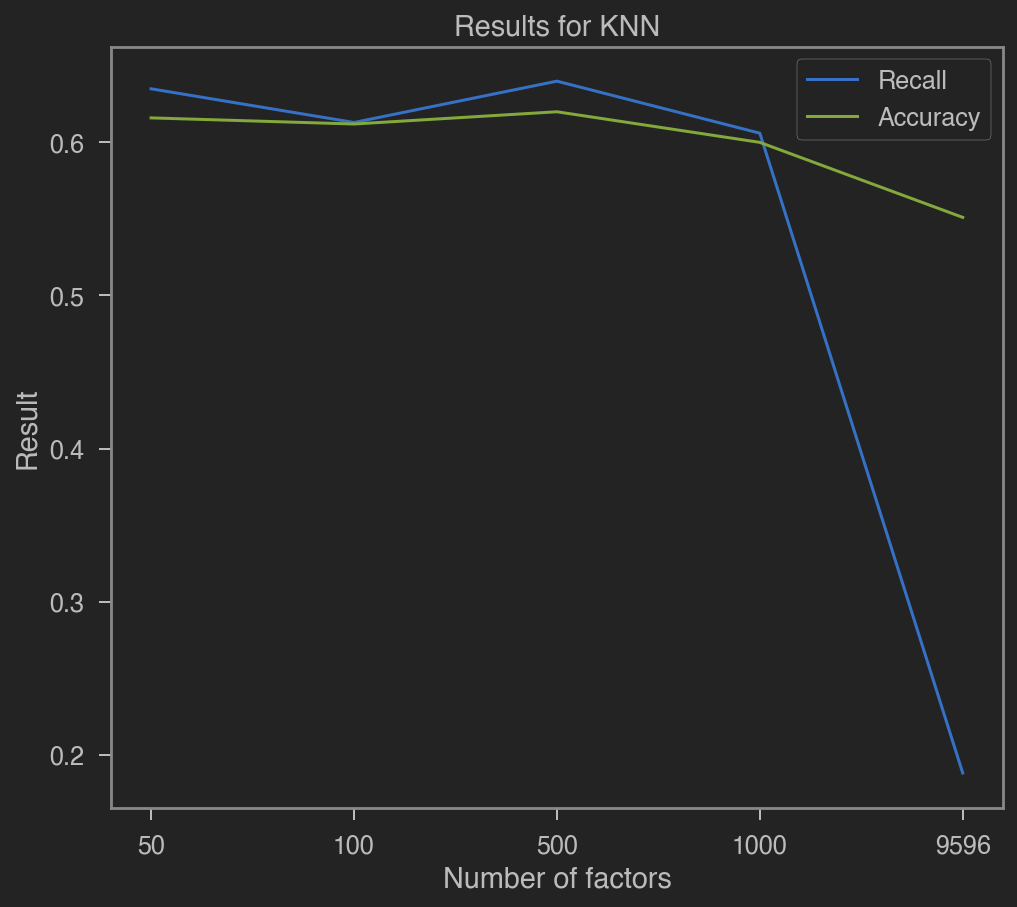

In [149]:
plt.plot(factors, recall_knn, accuracy_knn)
plt.legend(['Recall', 'Accuracy'])
plt.title('Results for KNN')
plt.xlabel('Number of factors')
plt.ylabel('Result')

In [146]:
# plot SVM accuracy and recall for different number of factors

Text(0, 0.5, 'Result')

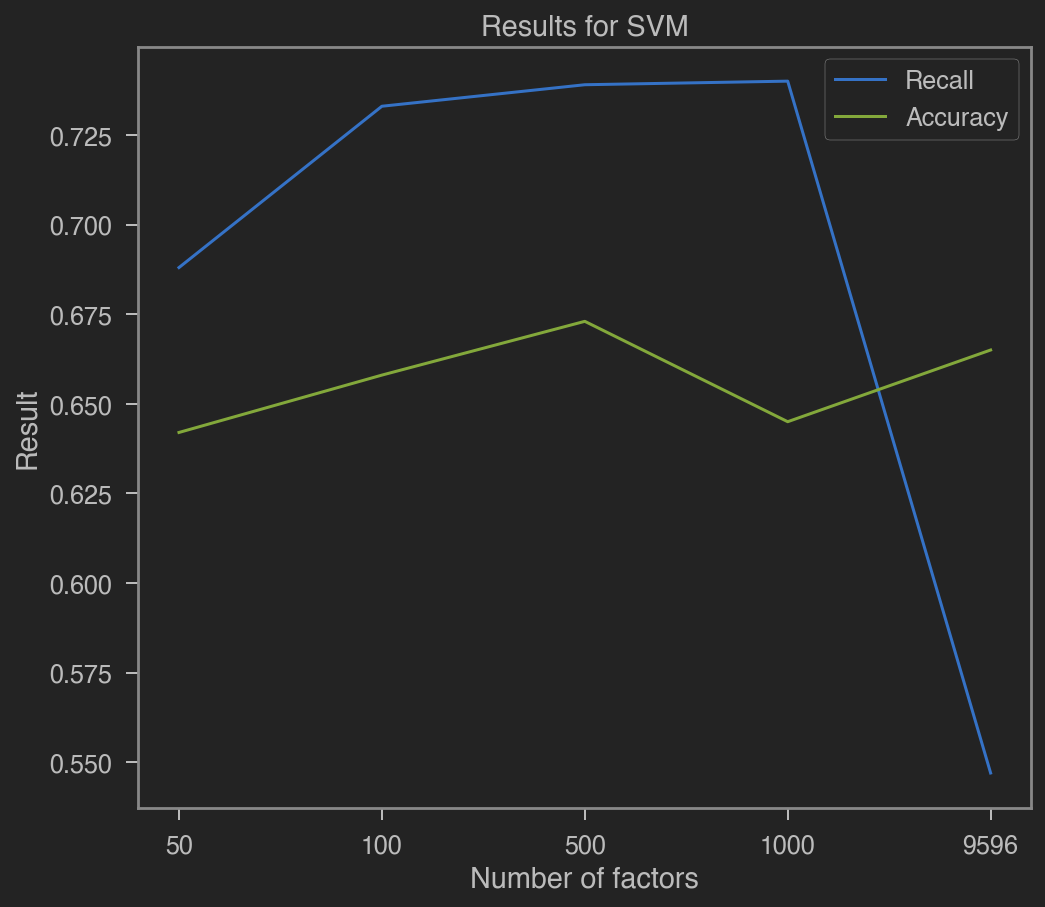

In [150]:
plt.plot(factors, recall_svm, accuracy_svm)
plt.legend(['Recall', 'Accuracy'])
plt.title('Results for SVM')
plt.xlabel('Number of factors')
plt.ylabel('Result')